![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [2]:
import unidecode
import string
import random
import re


#all_characters = string.printable
#n_characters = len(all_characters)
#print(n_characters)
#print(all_characters)
file = unidecode.unidecode(open('sherlock_holmes_all.txt').read())  #unicode to ascii
#file = unidecode.unidecode(open('shakespeare.txt').read())  #unicode to ascii
#text = open(f'{PATH}nietzsche.txt').read()
file_len = len(file)
print('file_len =', file_len)  #basically nuumber of characters
#print(file) #print whole file

#all_characters = string.printable
#n_characters = len(all_characters)
#print(n_characters)
#print(all_characters)
all_characters = sorted(list(set(file)))
n_characters = len(all_characters)
print(n_characters)
print(all_characters)

file_len = 2046653
81
['\t', '\n', ' ', '!', '"', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
file[0:100]

'\n\n\n\n\t\t\t\t\tTHE ADVENTURES OF SHERLOCK HOLMES\n\n\t\t\t\t\t\t   Arthur Conan Doyle\n\n\n\n\t\t\t\t\t\t\tTable of contents\n'

In [4]:
# all_characters.insert(0, "\0")

# ''.join(all_characters[1:-6])

To make inputs out of this big string of data, we will be splitting it into chunks.

In [5]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)  #start index
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())  #give a 500 length sentence randomly each time

ts of the little town, finally returning to the hotel, where I
 lay upon the sofa and tried to interest myself in a yellow-backed
 novel. The puny plot of the story was so thin, however, when compared
 to the deep mystery through which we were groping, and I found my
 attention wander so continually from the action to the fact, that I
 at last flung it across the room and gave myself up entirely to a
 consideration of the events of the day. Supposing that this unhappy
 young man's story were abso


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder_ = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,dropout=0.5)
        #self.dropout2=nn.Dropout2d()
        self.decoder_ = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_, hidden):
        input_=input_.to(device)
        input_ = self.encoder_(input_.view(1, -1))
        output, hidden = self.gru(input_.view(1, 1, -1), hidden)
        #output=self.dropout2(output)
        output = self.decoder_(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size)).to(device)

cuda


# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [7]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 55,  56,  57,  29,  30,  31])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [8]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
   # target=torch.LongTensor([target])
    return inp, target

print(random_training_set())

(tensor([ 76,  59,  72,   2,  74,  62,  59,   2,  61,  72,  59,  55,
         74,   2,  57,  63,  74,  79,  11,   1,   2,  44,  62,  59,
         72,  66,  69,  57,  65,   2,  33,  69,  66,  67,  59,  73,
          2,  77,  55,  73,   2,  55,  66,  72,  59,  55,  58,  79,
          2,  55,  74,   2,  56,  72,  59,  55,  65,  60,  55,  73,
         74,   2,  77,  62,  59,  68,   2,  34,   2,  57,  55,  67,
         59,   2,  58,  69,  77,  68,  11,   1,   1,   2,   4,  50,
         69,  75,   2,  77,  63,  66,  66,   2,  59,  78,  57,  75,
         73,  59,   2,  67,  59,   2,  60,  69,  72,   2,  68,  69,
         74,   2,  77,  55,  63,  74,  63,  68,  61,   2,  60,  69,
         72,   2,  79,  69,  75,   9,   4,   2,  73,  55,  63,  58,
          2,  62,  59,  24,   2,   4,  34,   2,  62,  55,  76,  59,
          9,   2,  34,   1,   2,  60,  69,  72,  59,  73,  59,  59,
          9,   2,  55,   2,  76,  59,  72,  79,   2,  56,  75,  73,
         79,   2,  58,  55,  79,   2,  56,  59,

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [9]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    decoder.eval()
    
    with torch.no_grad():

        hidden = decoder.init_hidden()
        prime_input = char_tensor(prime_str)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = decoder(prime_input[p], hidden)
        inp = prime_input[-1]

        for p in range(predict_len):
            output, hidden = decoder(inp, hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = char_tensor(predicted_char)
    decoder.train()        

    return predicted

# Training

A helper to print the amount of time passed:

In [10]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [11]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0


    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        #output = output.unsqueeze(0)
        #target[c]=torch.LongTensor([target[c]])
        target_=torch.tensor([target[c]]).to(device)
        loss += criterion(output, target_)

    loss.backward()
    decoder_optimizer.step()
   # print(loss)


    return loss.data / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [12]:
n_epochs = 30000
print_every = 1000
plot_every = 1000
hidden_size = 200
n_layers = 3
lr = 0.001

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
#decoder_optimizer=torch.optim.RMSprop(decoder.parameters())
criterion = nn.CrossEntropyLoss()

decoder.to(device)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    decoder.train()
    xx,yy=random_training_set()
    #print(xx,yy)
    xx=xx.to(device)
    yy=yy.to(device)
    loss = train(xx,yy)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        decoder.eval()
        print(evaluate('Ho', 400), '\n')
        #print(evaluate('Wa', 200), '\n')
        decoder.train()
        
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
        
    if epoch % 5000==0:
        
        path_='holmes_30k_001_drop_'+str(epoch)+'.pth'
        torch.save(decoder.state_dict(), path_)
        
        

 47s (1000 3%) 1.6627]
Home, and fear you have lirge our onger, sime the farted it which come, you was could
 a manes."

 "We do simy eve no would the head. Leasty, and man this light the is that me. The being and you
 alsered but roum in he canthing of can this and was heard of the duther. It in the nevery gornoms," so were me the dave and hadk dy to dears wometed to the pisitable-so him you that as my clad a
 dacked you 

 44s (2000 6%) 1.8550]
Hover.

 "And the poils of the me. Dows if I parctod and were had be the sase him person in his
 known.  Mr. Holmes, I have can and that," shom the lught. I langed
 the doon. Now even such a knowing any recristlement linite. I arred, door of the long and
 an alsome stranger. But I surpreated a looks her
 recrambed in his decorcull notked to exciping of occoursely lay of remark his being,
 and not he 

 11s (3000 10%) 1.7199]
Hould enough good to sid. They my ask in the
 consaid, that he had been have bidy we was before the birded from her
 fea

 41s (20000 66%) 1.4256]
However, I written the room, which
 had glad in have she could take for the picks of his instant. I found his conscious way to you
 know the stidd of the presents. That are in a question of
 the darkless maids. His lal was suddenly knowledge to my known my
 planed, and it was a burrial upon the whole strong, and he had
 that there is round the thick and had sudderly slight, had been faint
 had the f 

 27s (21000 70%) 1.3925]
How my flight--unusual as he
 should man would companion to state Hildal handly I know that you know a little
 sound. I can thinks ago every tempers of it. Now were percope the police,
 and it is the Corner was some expection of surply which I was look estant on the
 side. There is in this who fell. Then, who saw him, and I cannot every passive in onch
 head it as I should be the face, and I could e 

 18s (22000 73%) 1.2775]
Hook from this opened action. It was a more. One shown very
 event and my will some packet manner with me of the ex

In [ ]:
n_epochs = 30000
print_every = 1000
plot_every = 1000
hidden_size = 200
n_layers = 3
lr = 0.0005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
decoder.load_state_dict(torch.load('holmes_30k_001_drop_30000.pth'))
#decoder_optimizer=torch.optim.RMSprop(decoder.parameters())
criterion = nn.CrossEntropyLoss()

decoder.to(device)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    decoder.train()
    xx,yy=random_training_set()
    #print(xx,yy)
    xx=xx.to(device)
    yy=yy.to(device)
    loss = train(xx,yy)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        decoder.eval()
        print(evaluate('Ho', 400), '\n')
        #print(evaluate('Wa', 200), '\n')
        decoder.train()
        
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
        
    if epoch % 5000==0:
        
        path_='holmes_30k_001_drop_'+str(epoch+30000)+'.pth'
        torch.save(decoder.state_dict(), path_)
        
        

 43s (1000 3%) 1.2711]
However that
 he must have all rather who was the only stand.

 "An and you wripped that you rest quite some next good trug down,
 and the lady was nearly an oakled overtour who was a shoulds had been a
 very clear. And the same seemed of a minute face is a red in the one of cheming of our look of the face. I
 must comy mind which her years and made no Police, Mr. Holmes, he
 had every had seen our  

 36s (2000 6%) 1.2815]
Hould both to tell your little an old
 Mear book, hind have you all that our work. The first man have a
 small criminal stand of the most close, and even we found away
 the might important of event, sir, which is cuning the boots in the enter
 of it in the instrection's broeger of his story. As evident which
 had been at the wrack. There was for about this very pearbing more
 things of the visitor's 

 47s (3000 10%) 1.3176]
How she redary, the
 removed to me. Your hundred of ubone
 discollected a tugn of cheek with the house's fact, an instan

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

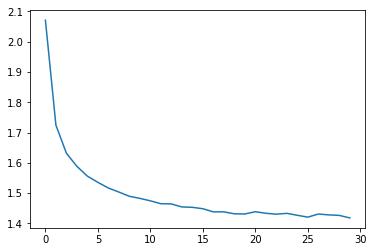

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [49]:
print(evaluate('Professor Moriarty', 200, temperature=0.5))

Professor Moriarty off the start that it day by the
 possible of the friend for the place which you may have good at the tably revark the man his see my stains
 of the spreasion and more probaculance."

 "You can a spa


In [50]:
print(evaluate('Dr. watso', 200, temperature=0.8))


Dr. watson, speating last was
 into this revorrised upon the bragan. On the voicion who was events to had been the possipies."

 "Yive to known. "We amaining near fisses however and a spresen, and his out of h


In [51]:
print(evaluate('Holm', 200, temperature=1.4))

Holmes. Therhorc little at that
 were." Farture. Their doorece. By about Farcreck. "Loed Tos askadling tembournesl pro"che custeawmain." he past turn
 Gromaper strop. Agaying four, "I dot your faning, I'k


In [52]:
print(evaluate('Holm', 200, temperature=1.0))

Holmes evere an cruring of his rooms, show has hear in his hand lank by
 some remotter of about it will do Cust. Why is a fresrublabthy which is
 alread time. Once has have in visation of the faturejuch, 


In [53]:
print(evaluate('Holm', 200, temperature=0.9))

Holmes a devangs, as the may very bedre craw a two deterving thit after the pullress. I
 has the poplened his putterage little and him, peting which he had nevil, for he have bother, a
 that paminatered t


In [54]:
print(evaluate('Holm', 200, temperature=0.8))

Holmes, Watson," said Holmes came take a bloth by
 Holmes. No the proefuted to see a straggere whole a most offlition the
 side before no requarticed the case?"

 "It as have know, and he was again for a 


In [55]:
print(evaluate('Holm', 200, temperature=0.7))

Holmes.

 "Look anything at the paper. My adfering as new about the for to be any marking in the mittle that
 him. The cream. I am about your explessers. That have a life I langer and as my
 away. It real


In [56]:
print(evaluate('Holm', 200, temperature=0.6))

Holmes. The pliver of the so said his
 hands of fached the possain which I had been a gener. They start his proses of my sir, and
 you conture to professight that I had been the own to peess the more from


In [57]:
print(evaluate('Holm', 200, temperature=0.5))

Holmes, and the propage of the hand in the
 man him of the not paper. The should be the pack of the more of the start of the started of the
 most as profied of the strange at the probarms start and all th


Lower temperatures are less varied, choosing only the more probable outputs:

In [58]:
print(evaluate('Holm', 200, temperature=0.2))

Holmes as the ready and the start of the started that he was a bention which has a man the prome and the strange and the started
 the possible of the man the possible of the stain the part of the stranger


Higher temperatures more varied, choosing less probable outputs:

In [59]:
print(evaluate('Holm', 200, temperature=0.1))

Holmes and the paper of the starting that
 the passion of the start that the start that the possible that the proble that the probless of
 the probless of the start and the possible of the starting that h


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)